## Generative Adversarial Networks (GAN)

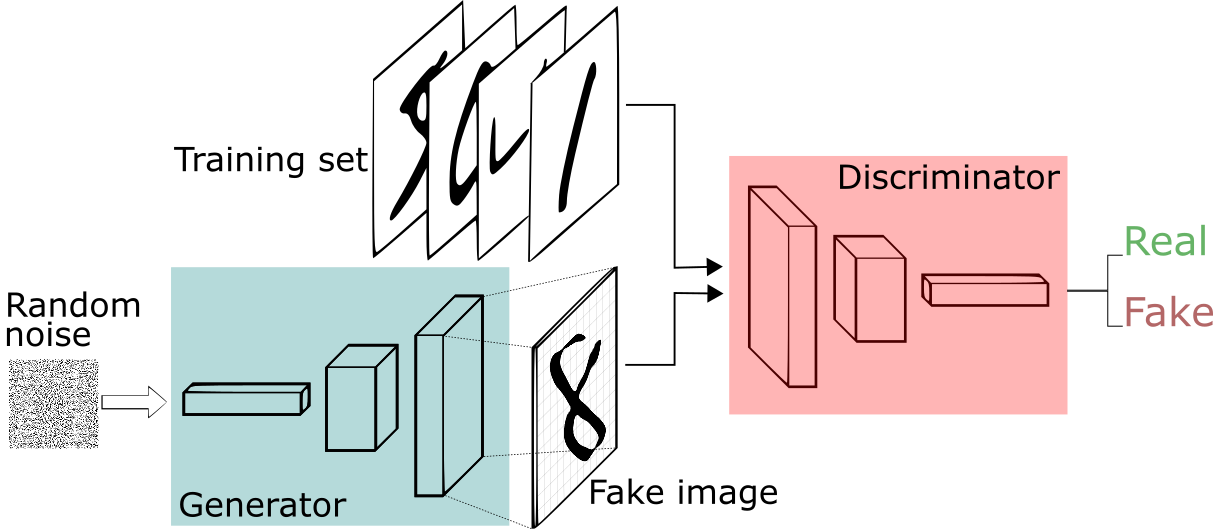

* randomness
* pooling -> strides
* ReLU -> leakyReLU

In [17]:
# MNIST
import numpy as np
from tensorflow import keras
from keras import models 
from keras import layers
from keras.datasets import mnist
from keras.utils import to_categorical
import matplotlib.pyplot as plt

In [18]:
# generator: g(noise) -> fake image
latent_dim = 100
length = 28
channels = 1

generator_input = layers.Input(shape=(latent_dim, )) 

x = layers.Dense(128 * 7 * 7)(generator_input)
x = layers.Reshape((7,7,128))(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding='same', activation='selu')(x)
x = layers.BatchNormalization()(x)

x = layers.Conv2DTranspose(channels, kernel_size=5, strides=2, activation='tanh', padding='same')(x)

generator = models.Model(generator_input, x)
generator.summary()

Model: "functional_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense_5 (Dense)              (None, 6272)              633472    
_________________________________________________________________
reshape_2 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 14, 14, 64)        204864    
_________________________________________________________________
batch_normalization_5 (Batch (None, 14, 14, 64)      

In [19]:
discriminator_input = layers.Input(shape=(length, length, channels))

x = layers.Conv2D(64, kernel_size=5, strides=2, padding='same')(discriminator_input)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)

x = layers.Conv2D(128,  kernel_size=5, strides=2, padding='same')(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
 
x = layers.Flatten()(x)
x = layers.Dense(1, activation='sigmoid')(x) # 분류

discriminator = models.Model(discriminator_input, x)
discriminator.summary()

discriminator.compile(loss='binary_crossentropy', optimizer='nadam')


Model: "functional_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 7, 7, 128)       

In [20]:
gin = layers.Input(shape=(latent_dim,))
gout = discriminator(generator(gin))

gan = models.Model(gin, gout) 

discriminator.trainable = False # discriminator는 훈련하지 않음
gan.compile(loss='binary_crossentropy', optimizer='nadam')
gan.summary()

Model: "functional_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
functional_13 (Functional)   (None, 28, 28, 1)         840705    
_________________________________________________________________
functional_15 (Functional)   (None, 1)                 212865    
Total params: 1,053,570
Trainable params: 840,321
Non-trainable params: 213,249
_________________________________________________________________


#### GAN training
1. random noise
2. generator(noise)
3. real images / fake images
4. discriminator

In [21]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_train = X_train/255
X_train = X_train*2 -1

In [36]:
batch_size = 64
epochs = 1001

def gan_train(epochs, batch_size):    
    true = np.ones((batch_size,1))
    fake = np.zeros((batch_size,1))

    for i in range(epochs):
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        img = X_train[idx]
        loss_real = discriminator.train_on_batch(img, true)
 
        # fake 이미지
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        gen = generator.predict(noise)
        loss_fake = discriminator.train_on_batch(gen, fake)
 
        # 오차 계산
        d_loss = 0.5 * np.add(loss_real, loss_fake)
        g_loss = gan.train_on_batch(noise, true)

        
        if i % 100 == 0:
            noise = np.random.normal(0,1,(batch_size,latent_dim))
            im=generator.predict(noise)
            plt.figure()
            
            plt.subplot(141)
            plt.imshow(im[0, :, :, 0])
            
            plt.subplot(142)
            plt.imshow(im[1, :, :, 0])

            plt.subplot(143)
            plt.imshow(im[2, :, :, 0])

            plt.subplot(144)
            plt.imshow(im[3, :, :, 0])

            plt.show()
            print('epoch:%d' % i, ' d_loss:%.4f' % d_loss, ' g_loss:%.4f' % g_loss)

In [ ]:
epochs = 1001
batch_size = 64
gan_train(epochs,batch_size)

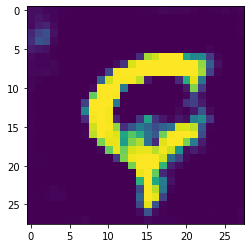

In [398]:
noise = np.random.normal(0,1,(batch_size,latent_dim))
im=generator.predict(noise)
plt.imshow(im[0, :, :, 0])

#### This person does not exist
* https://thispersondoesnotexist.com/